In [34]:
from datetime import datetime, timedelta
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

from dotenv import load_dotenv
import os

load_dotenv()


True

In [35]:
TOKEN = os.getenv("TOKEN")
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - relativedelta(years=4)
SHORT_WINDOW_SIZE = 50
LONG_WINDOW_SIZE = 200
LKOH = "BBG004731032"
data_candle = []
initial_capital = 50_000


In [36]:
with Client(TOKEN) as c:
    for candle in c.get_all_candles(
        instrument_id=LKOH,
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_candle.append({
            'date': candle.time.date(),
            'price': candle.close.units + candle.close.nano / 1e9,
        })

df_lkoh = pd.DataFrame(data_candle)
df_lkoh.set_index('date', inplace=True)

df_lkoh["sma_short"] = df_lkoh["price"].rolling(SHORT_WINDOW_SIZE).mean()
df_lkoh["sma_long"] = df_lkoh["price"].rolling(LONG_WINDOW_SIZE).mean()



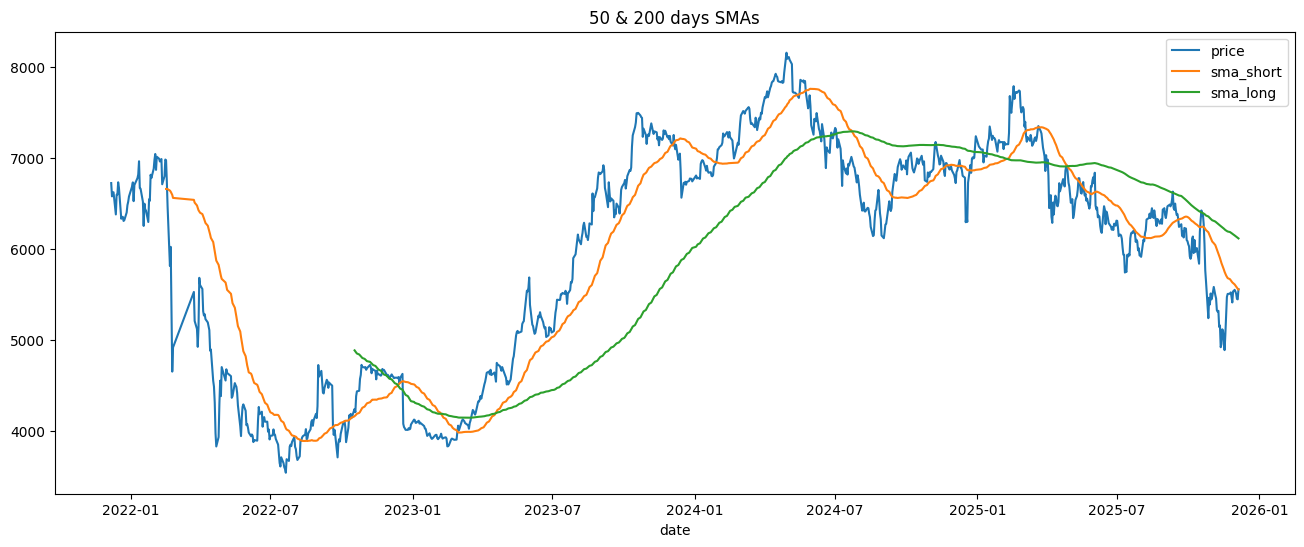

In [37]:

df_lkoh.plot(title=f'{SHORT_WINDOW_SIZE} & {LONG_WINDOW_SIZE} days SMAs', figsize=(16, 6));

In [40]:
df = df_lkoh.copy().dropna()
df["signal"] = np.where(df["sma_short"] > df["sma_long"], 1, -1)
df.dropna(inplace=True)  # for sure

In [58]:
def simple_backtest(df, deposit, commission):
    result_df = df.copy()
    shares = 0
    in_position = False

    portfolio_values = []
    actions = []

    for i in range(len(result_df)):
        current_price = result_df.iloc[i]['price']
        signal = result_df.iloc[i]['signal']

        if signal == 1 and not in_position:
            shares = deposit / current_price
            commission_cost = shares * current_price * commission
            deposit = -commission_cost
            in_position = True
            action = 'BUY'
        elif signal == -1 and in_position:
            deposit = shares * current_price
            commission_cost = deposit * commission
            deposit -= commission_cost
            shares = 0
            in_position = False
            action = 'SELL'
        else:
            action = 'HOLD'

        # Рассчитываем стоимость портфеля
        portfolio_value = deposit + (shares * current_price)
        portfolio_values.append(portfolio_value)
        actions.append(action)

    result_df['portfolio_value'] = portfolio_values
    result_df['action'] = actions
    result_df['daily_return'] = result_df['portfolio_value'].pct_change()

    return result_df

deposit = 100_000
result_df = simple_backtest(df, deposit, 0.04)
final_value = result_df['portfolio_value'].iloc[-1]
total_return = (final_value - deposit) / deposit * 100
print(f"{round(final_value, 2)} rub,  {round(total_return, 2)}%")

112523.8 rub,  12.52%
